# Manual contributor

This notebook extracts contribution tree data that has been exported manually
(copy-pasted) from openLCA into an Excel file, in the format shown in the
picture below.

<img src="manual_excel_example.png">

In [45]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
scenario = 'Baseline'
category = 'HTc'

In [161]:
df = pd.read_excel(f'..\{scenario}_contributions.xlsx', category).dropna()

sub_processes = []

for i,row in df.iterrows():
    if row['Process'].startswith(scenario):
        sub = ' '.join(row['Process'].split(' ')[3:][:-2])
        sub_processes.append([])
        row['Process'] = f'Direct, {sub}'
        row[df.columns[4]] = row[df.columns[5]]
    if row['Process'] != 'Process':
        row['Sub-process'] = sub
        sub_processes[-1].append(row)

new_rows = []
for sub in sub_processes[::-1]:
    for row in sub:
        new_rows.append(row)

df = pd.DataFrame(new_rows)
df.reset_index(drop=True, inplace=True)

for i,row in df.iterrows():
    split_row = row[1].split(' | ')
    process = split_row[0]
    if process.startswith('market for '):
        process = process[11:]
    elif process.startswith('market group for '):
        process = process[17:]
    elif process.endswith('production'):
        process = process[:-11]
    if 'without water' in process:
        split = process.split(',')
        process = split[0]
    df.loc[i, 'Process'] = process

categories = pd.read_excel(f'..\{scenario}_contributions.xlsx', 'General')
category_name = categories[categories['Sheet name'] == category]['Impact category'].values[0]
category_units = ''.join(['[', df.columns[4].split('[')[-1]])

In [162]:
pivot_df = df.pivot(index='Sub-process', columns='Process', values=df.columns[4]).fillna(0)
# pivot_df = pivot_df.iloc[:, 7:]
pivot_df = pivot_df.reindex(index=df['Sub-process'].unique(), columns=df['Process'].unique())
pivot_df

Process,"Direct, Leaching",sulfuric acid,hydrogen peroxide,"electricity, medium voltage",tap water,"Direct, Solution purification","hazardous waste, for underground deposit",sodium hydroxide,hydrogen sulfide,"copper concentrate, sulfide ore",...,"Direct, Ni recovery",nickel sulfate,"Direct, Li recovery","soda ash, dense",lithium carbonate,"sodium sulfate, anhydrite","Direct, Effluent treatment","quicklime, milled, packed","wastewater, unpolluted","wastewater, average"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Leaching,0.0,4.373509e-06,1.457620e-06,7.208126e-08,4.423201e-08,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Solution purification,0.0,0.000000e+00,2.659768e-11,2.142332e-07,9.669966e-09,0.0,0.000013,1.757060e-06,3.241429e-07,-5.131894e-07,...,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Mn recovery,0.0,6.467631e-07,0.000000e+00,1.334792e-07,6.069031e-09,0.0,0.000000,2.071020e-07,0.000000e+00,0.000000e+00,...,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Co recovery,0.0,6.845069e-07,0.000000e+00,1.148961e-07,8.147938e-09,0.0,0.000000,1.299124e-06,0.000000e+00,0.000000e+00,...,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Ni recovery,0.0,2.103516e-06,0.000000e+00,8.974433e-08,1.689151e-08,0.0,0.000000,1.435496e-06,0.000000e+00,0.000000e+00,...,0.0,-0.00004,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Li recovery,0.0,0.000000e+00,0.000000e+00,3.164976e-07,1.820758e-08,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.00000,0.0,0.000013,-0.000005,-0.000006,0.0,0.000000e+00,0.000000e+00,0.000000e+00
Effluent treatment,0.0,0.000000e+00,0.000000e+00,2.956523e-07,1.496766e-08,0.0,0.000013,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,6.156988e-08,2.333808e-08,1.470204e-08


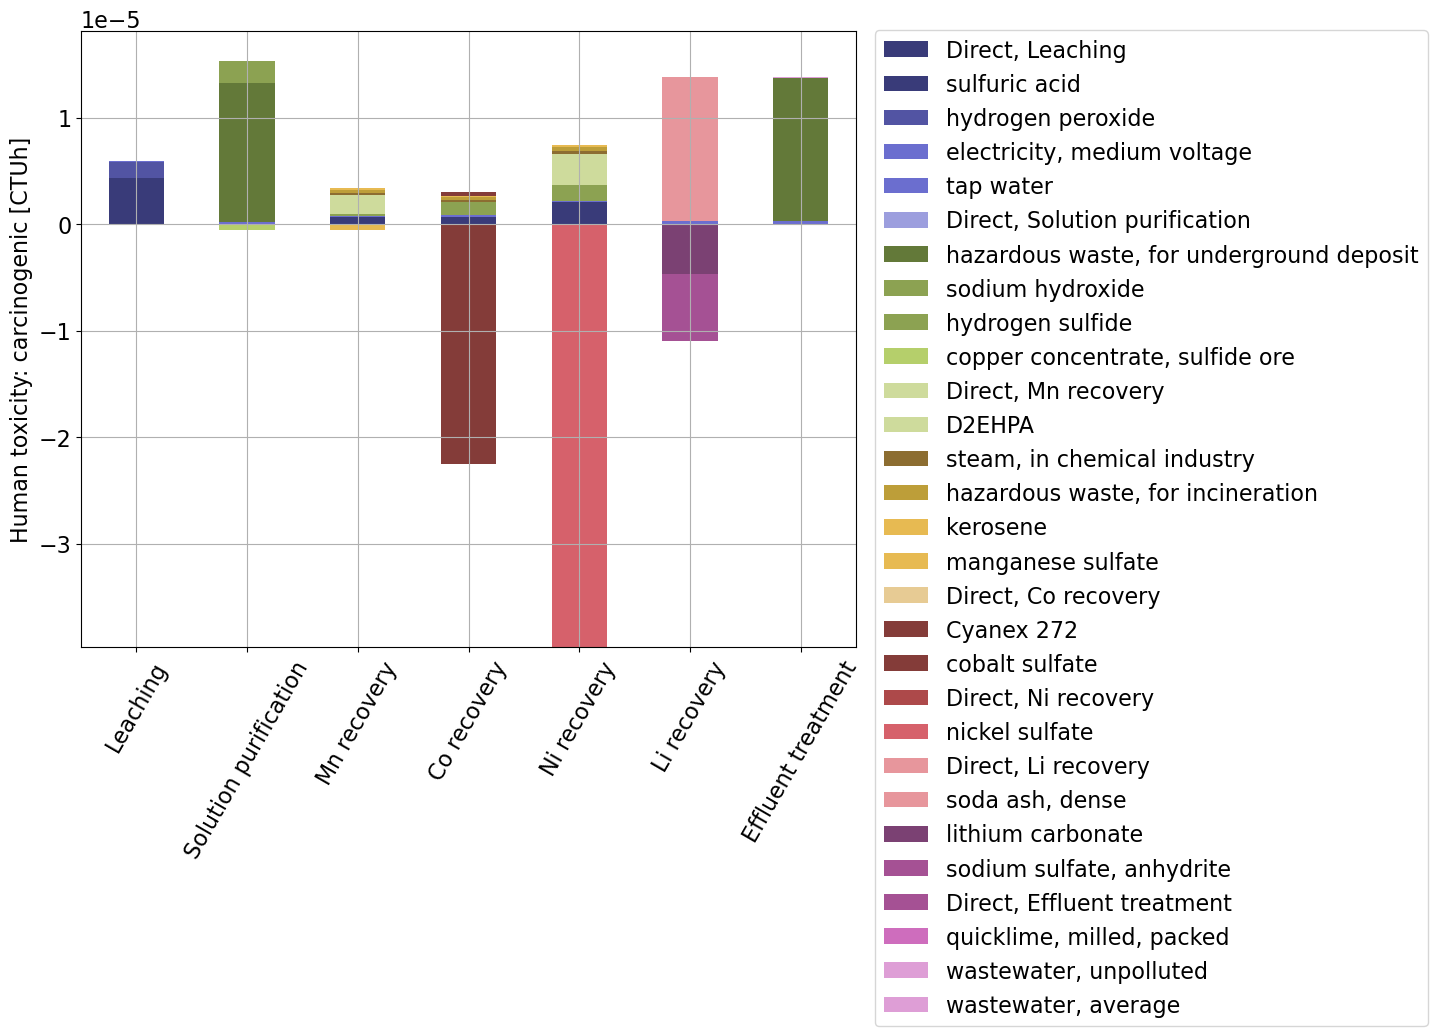

In [167]:
fig, ax = plt.subplots(figsize=(10, 8))

my_cmap = mpl.colormaps['tab20b']

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.xlabel('')
plt.xticks(rotation=60)
# plt.ylim([-4.5e-5, 2e-5])
plt.ylabel(category_name + ' ' + category_units)
mpl.rcParams.update({'font.size': 16})

plt.show()